# Data Preprocess

In [2]:
def rename_variables(df_variables):
    df_variables['wind_actual'] = df_variables['generation_wind_offshore_actual'] + df_variables['generation_wind_onshore_actual']
    df_variables['wind_forecast'] = df_variables['generation_wind_offshore_forecast'] + df_variables['generation_wind_onshore_forecast']
    df_variables = df_variables.rename(columns={"generation_solar_actual":"solar_actual", "generation_solar_forecast": "solar_forecast"})
    df_variables = df_variables.drop(columns=['generation_wind_offshore_actual', 'generation_wind_onshore_actual', 'generation_wind_offshore_forecast', 'generation_wind_onshore_forecast','delivery_time'])
    return df_variables

In [3]:
def remove_outliers(df: pd.DataFrame, cols, drop_cols=('close',)):
    """
    For each col in `cols`:
      - compute the 99th percentile of absolute values
      - if col in `drop_cols`: drop rows where |col| > threshold
      - else: clip to [-threshold, +threshold]
    Returns cleaned df and thresholds dict.
    """
    df_clean = df.copy()
    #before = df_clean['delivery_time'].nunique()

    mask = pd.Series(True, index=df_clean.index)

    thresholds = {}
    for col in cols:
        # skip non-numeric columns safely
        if not pd.api.types.is_numeric_dtype(df_clean[col]):
            continue
        thr = np.percentile(np.abs(df_clean[col].dropna()), 99)
        thresholds[col] = thr
        
        if col in drop_cols:
            # mark rows to keep for this column
            mask &= (np.abs(df_clean[col]) <= thr)
        else:
            # clip (no row removal)
            df_clean[col] = df_clean[col].clip(lower=-thr, upper=thr)

    # apply dropping once at the end (affects all columns consistently)
    df_clean = df_clean[mask]

    #after = df_clean['delivery_time'].nunique()
    #print(f"before remove outlier {before}")
    #print(f"after remove outlier  {after}")

    return df_clean

In [4]:
def get_delivery_time(df):
    df['weekday_num'] = df['ExecutionTime'].dt.weekday
    df['ID_weekday_num'] = df['ID'].str[:3]
    df['ID_weekday_num'] = df['ID_weekday_num'].replace({'Mon':0, 'Tue':1, 'Wed':2,
                                                         'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6})
    df['days_to_add'] = (df['ID_weekday_num'] - df['weekday_num'])%7
    df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'],unit='d')
    hours = df['ID'].str[3:5].astype(int)
    minutes = ((df['ID'].str[-1].astype(int) - 1) * 15)
    df['delivery_time'] = pd.to_datetime(df['delivery_date']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
    df = df.drop(columns=['weekday_num','ID_weekday_num','days_to_add','delivery_date'])

    return df

In [5]:
df_train = pd.read_parquet('train_fullyears.parquet') # replace this with the orginal code
df_test = pd.read_parquet('test_2024.parquet')

df_train_variables = pd.read_parquet('df_train_variables.parquet')
df_test_variables = pd.read_parquet('df_test_variables.parquet')

df_train['ExecutionTime'] = df_train['ExecutionTime'].dt.tz_localize(None)
df_test['ExecutionTime'] = df_test['ExecutionTime'].dt.tz_localize(None)

print(f"train set shape: {df_train.shape}")
print(f"test set shape: {df_test.shape}")
print(f"train set external variables shape: {df_train_variables.shape}")
print(f"test set external variables shape: {df_test_variables.shape}")

train set shape: (8147689, 6)
test set shape: (1712420, 8)
train set external variables shape: (103968, 16)
test set external variables shape: (22556, 16)


In [6]:
pd.set_option("display.float_format", "{:.6f}".format) 
df_train.describe()

ExecutionTime           high            low  \
count                     8147689 8147689.000000 8147689.000000   
mean   2022-07-09 01:01:26.806592     154.136442     148.191108   
min           2021-01-06 21:45:00   -2318.860000   -2882.710000   
25%           2021-10-20 17:00:00      76.540000      72.910000   
50%           2022-07-07 22:00:00     116.740000     112.210000   
75%           2023-03-30 07:00:00     197.000000     190.700000   
max           2023-12-24 22:45:00    9999.000000    7655.300000   
std                           NaN     125.577957     121.437967   

               close         volume  
count 8147689.000000 8147689.000000  
mean      151.143755       4.219791  
min     -2318.860000       0.000000  
25%        74.800000       0.000000  
50%       114.480000       0.100000  
75%       193.900000       2.500000  
max      9000.000000    1201.825000  
std       123.180672      11.596550

In [ ]:
df_train_variables = rename_variables(df_train_variables)
df_test_variables = rename_variables(df_test_variables)

df_train_variables.describe()

timestamp  day_ahead_price  load_forecast  \
count                         103968    103968.000000  103776.000000   
mean   2022-07-02 11:52:30.000000256       144.785798   55266.637932   
min              2021-01-07 00:00:00      -149.990000   30739.000000   
25%              2021-10-04 17:56:15        66.500000   47767.000000   
50%              2022-07-02 11:52:30       109.095000   55156.000000   
75%              2023-03-30 05:48:45       186.402500   63046.000000   
max              2023-12-25 23:45:00      2999.990000   78313.000000   
std                              NaN       123.644468    9310.078230   

         load_actual   solar_actual  solar_forecast  temperature_rounded  \
count  103968.000000  103968.000000   103968.000000        103968.000000   
mean    55604.245999    6076.179882     6082.404807            10.130776   
min     28308.000000       0.000000        0.000000           -12.290000   
25%     47681.750000       3.000000        0.000000             4.295000   
50%     55577.500000     115.000000      192.000000             9.705000   
75%     63244.000000    9782.000000     9824.250000            15.717500   
max     82417.000000   41687.000000    41763.000000            33.680000   
std      9778.161958    9366.241934     9302.718709             7.527149   

            imported       exported  imported_is_zero  exported_is_zero  \
count  103968.000000  103968.000000     103968.000000     103968.000000   
mean      672.098492    1552.820220          0.155057          0.093625   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000    1034.150000          0.000000          0.000000   
75%      1181.425000    2749.825000          0.000000          0.000000   
max      6098.400000    9236.200000          1.000000          1.000000   
std      1114.401056    1718.893088          0.361961          0.291308   

         wind_actual  wind_forecast  
count  103968.000000  103968.000000  
mean    14477.425251   14349.994590  
min       128.000000     241.000000  
25%      5697.000000    5629.000000  
50%     11357.500000   11089.000000  
75%     21341.000000   21054.000000  
max     53335.000000   50489.000000  
std     10886.353727   10909.184164

In [ ]:
value_cols = [c for c in df_train.columns if c not in ['ID', 'ExecutionTime','delivery_time','delivery_date']]
df_train = (df_train.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())
df_test = (df_test.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())

df_train = get_delivery_time(df_train)
df_test = get_delivery_time(df_test)

# merge
df_train = pd.merge(df_train, df_train_variables, left_on='delivery_time', right_on='timestamp', how='left')
df_test = pd.merge(df_test, df_test_variables, left_on='delivery_time', right_on='timestamp', how='left')
# remove outliers
df_train= remove_outliers(df_train, df_train.columns)
# add special period column
df_train['special_period'] = ( df_train['ExecutionTime'].between('2021-01-01', '2021-03-31') | df_train['ExecutionTime'].between('2022-02-24', '2022-12-31')).astype(int)
df_train.describe() # dont remove outliers for test set

ExecutionTime          high           low  \
count                        8065314  8.065314e+06  8.065314e+06   
mean   2022-07-08 13:57:40.579748352  1.486624e+02  1.429548e+02   
min              2021-01-06 21:45:00 -5.822900e+02 -5.750000e+02   
25%              2021-10-17 23:15:00  7.610000e+01  7.250000e+01   
50%              2022-07-03 07:00:00  1.157400e+02  1.112700e+02   
75%              2023-04-01 21:00:00  1.936100e+02  1.873100e+02   
max              2023-12-24 22:45:00  5.915100e+02  5.750000e+02   
std                              NaN  1.118843e+02  1.095342e+02   

              close        volume                  delivery_time  \
count  8.065314e+06  8.065314e+06                        8065314   
mean   1.457960e+02  3.975841e+00  2022-07-09 01:08:45.979696128   
min   -5.822900e+02  0.000000e+00            2021-01-06 22:00:00   
25%    7.436000e+01  0.000000e+00            2021-10-18 12:45:00   
50%    1.135000e+02  1.000000e-01            2022-07-03 19:15:00   
75%    1.903700e+02  2.500000e+00            2023-04-02 09:00:00   
max    5.828000e+02  5.817500e+01            2023-12-25 23:45:00   
std    1.106176e+02  9.733815e+00                            NaN   

                           timestamp  day_ahead_price  load_forecast  \
count                        8065278     8.065278e+06   8.049619e+06   
mean   2022-07-09 01:12:17.349438976     1.469443e+02   5.647488e+04   
min              2021-01-07 00:00:00    -1.499900e+02   3.073900e+04   
25%              2021-10-18 12:45:00     7.043000e+01   4.957900e+04   
50%              2022-07-03 19:15:00     1.149300e+02   5.685300e+04   
75%              2023-04-02 09:11:15     1.927200e+02   6.362200e+04   
max              2023-12-25 23:45:00     5.899400e+02   7.253200e+04   
std                              NaN     1.151888e+02   8.753073e+03   

        load_actual  solar_actual  solar_forecast  temperature_rounded  \
count  8.065278e+06  8.065278e+06    8.065278e+06         8.065278e+06   
mean   5.680084e+04  6.409631e+03    6.408219e+03         1.057907e+01   
min    2.830800e+04  0.000000e+00    0.000000e+00        -1.229000e+01   
25%    4.949600e+04  3.000000e+00    0.000000e+00         4.587500e+00   
50%    5.710500e+04  3.740000e+02    5.010000e+02         1.016000e+01   
75%    6.383200e+04  1.078600e+04    1.078100e+04         1.638250e+01   
max    7.588200e+04  3.456100e+04    3.426000e+04         2.735000e+01   
std    9.232382e+03  9.475082e+03    9.395451e+03         7.589634e+00   

           imported      exported  imported_is_zero  exported_is_zero  \
count  8.065278e+06  8.065278e+06      8.065278e+06      8.065278e+06   
mean   6.556931e+02  1.544880e+03      1.528309e-01      9.171922e-02   
min    0.000000e+00  0.000000e+00      0.000000e+00      0.000000e+00   
25%    0.000000e+00  0.000000e+00      0.000000e+00      0.000000e+00   
50%    0.000000e+00  1.042400e+03      0.000000e+00      0.000000e+00   
75%    1.166100e+03  2.749300e+03      0.000000e+00      0.000000e+00   
max    4.365300e+03  6.115900e+03      1.000000e+00      1.000000e+00   
std    1.081421e+03  1.690422e+03      3.598245e-01      2.886292e-01   

        wind_actual  wind_forecast  
count  8.065278e+06   8.065278e+06  
mean   1.451835e+04   1.436715e+04  
min    1.280000e+02   2.410000e+02  
25%    5.688000e+03   5.627000e+03  
50%    1.140900e+04   1.117700e+04  
75%    2.139400e+04   2.106700e+04  
max    4.473300e+04   4.439100e+04  
std    1.090052e+04   1.087654e+04

In [14]:
df_train.isnull().sum()

ID                         0
ExecutionTime              0
high                       0
low                        0
close                      0
volume                     0
delivery_time              0
timestamp                 36
day_ahead_price           36
load_forecast          15695
load_actual               36
solar_actual              36
solar_forecast            36
temperature_rounded       36
imported                  36
exported                  36
imported_is_zero          36
exported_is_zero          36
wind_actual               36
wind_forecast             36
dtype: int64

In [15]:
df_test.isnull().sum()

ID                      0
ExecutionTime           0
high                    0
low                     0
close                   0
volume                  0
delivery_time           0
timestamp               0
day_ahead_price         0
load_forecast           0
load_actual             0
solar_actual            0
solar_forecast          0
temperature_rounded    10
imported               15
exported               15
imported_is_zero       10
exported_is_zero       10
wind_actual             0
wind_forecast           0
dtype: int64

## Seasonality Check

In [112]:
import pandas as pd
import plotly.express as px

def seasonality_check_plot (df, group_by,template) :
    df['delivery_hour'] = df['delivery_time'].dt.hour
    m = df['delivery_time'].dt.month

    def month_to_season(x):
        return ("Spring" if x in [3,4,5] else
                "Summer" if x in [6,7,8] else
                "Autumn" if x in [9,10,11] else "Winter")

    def hour_to_period(h):
        if 7 <= h <= 9:   return "Morning Peak"
        if 17 <= h <= 19: return "Evening Peak"
        if 10 <= h <= 16: return "Daytime"
        if 20 <= h <= 23: return "Night"
        return "Late Night"

    df['season'] = m.map(month_to_season)
    df['delivery_period'] = df['delivery_hour'].map(hour_to_period)

    period_order = ["Morning Peak","Daytime","Evening Peak","Night","Late Night"]
    season_order = ["Spring","Summer","Autumn","Winter"]

    if group_by == 'season': 
        fig = px.violin( 
            df, 
            x="season", 
            y="close", 
            box=True, 
            points=False, 
            template = template,
            category_orders={"season": ["Spring","Summer","Autumn","Winter"]}, 
                labels={"season":"Season", "close":"Close Price"}, 
                title="Close Price Distribution x Delivery Season (Outliers Removed)" )
        fig.update_layout() 
        fig.show()
    
    elif group_by == 'period':
        fig = px.violin( 
            df, 
            x="delivery_period", 
            y="close", 
            box=True, 
            points=False, 
            template = template,
            category_orders={"period": ["Morning<br>Peak","Daytime","Evening<br>Peak","Night","Late<br>Night" ]}, 
                labels={"period":"Period", "close":"Close Price"}, 
                title="Close Price Distribution x Delivery Period (Outliers Removed)" )
        fig.update_layout() 
        fig.show()

    elif group_by == 'seasonXperiod':
        fig = px.violin(
            df,
            x="season",
            y="close",
            color="delivery_period",   # legend instead of facet
            box=True,
            points=False,
            template = template,
            category_orders={"season": season_order, "delivery_period": period_order},
            labels={
                "season": "Season",
                "delivery_period": "Delivery Period",
                "close": "Close Price"
            },
            title="Close Price Distribution by Season and Delivery Period (Outliers Removed)"
        )

        fig.update_layout(
            legend_title="Delivery Period",
            margin=dict(l=40,r=20,t=60,b=40),
            width=1000,   # pixels
            height=400,
            legend=dict(
                x=0.95,          # horizontal position (default ~1.05)
                y=1,             # vertical position (1 = top, 0 = bottom)
                xanchor="left",  # anchor the left side of legend box to x position
                yanchor="top"
    )
        )

        fig.show()


    elif group_by == 'periodXseason':
        fig = px.violin(
            df,
            x="delivery_period",      # now period on x-axis
            y="close",
            color="season",           # season as legend
            box=True,
            points=False,
            template = template,
            category_orders={"delivery_period": period_order, "season": season_order},
            labels={
                "delivery_period": "Delivery Period",
                "season": "Season",
                "close": "Close Price"
            },
            title="Close Price Distribution by Delivery Period and Season (Outliers Removed)"
        )

        fig.update_layout(
            legend_title="Season",
            margin=dict(l=40,r=20,t=60,b=40),
            width=1000,   # pixels
            height=400,
            legend=dict(
                x=0.95,          # horizontal position (default ~1.05)
                y=1,             # vertical position (1 = top, 0 = bottom)
                xanchor="left",  # anchor the left side of legend box to x position
                yanchor="top"
    )
        )

        fig.show()


In [114]:
df_train_2023 = df_train[df_train['delivery_time']>='2023-01-01 00:00:00']

In [115]:
seasonality_check_plot(df_train_2023, group_by='delivery_period', template='plotly_white')

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3363173123.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3363173123.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3363173123.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [117]:
# Load, Wind, Solar Check
df = df_train_variables[df_train_variables['timestamp'].dt.year==2023]

df['delivery_hour'] = df['timestamp'].dt.hour
m = df['timestamp'].dt.month

def month_to_season(x):
    return ("Spring" if x in [3,4,5] else
            "Summer" if x in [6,7,8] else
            "Autumn" if x in [9,10,11] else "Winter")

def hour_to_period(h):
    if 7 <= h <= 9:   return "Morning Peak"
    if 17 <= h <= 19: return "Evening Peak"
    if 10 <= h <= 16: return "Daytime"
    if 20 <= h <= 23: return "Night"
    return "Late Night"

df['season'] = m.map(month_to_season)
df['delivery_period'] = df['delivery_hour'].map(hour_to_period)

period_order = ["Morning Peak","Daytime","Evening Peak","Night","Late Night"]
season_order = ["Spring","Summer","Autumn","Winter"]


fig = px.violin( 
    df, 
    x="season", 
    y="wind_actual", 
    box=True, 
    points=False, 
   # template="ggplot2",
    category_orders={"season": ["Spring","Summer","Autumn","Winter"]}, 
        labels={"season":"Season", "wind_actual":"Wind Actual"}, 
        title="Wind Actual Distribution x Delivery Season (Outliers Removed)" )
fig.update_layout(
    title={
        "text": "Wind Actual Distribution x Delivery Season (Outliers Removed)",
        "y": 0.87,  
        "x": 0.1,      # move title closer (default ~0.95)
        "yanchor": "top"
    },
    width=700,   # pixels
    height=400,
    title_pad=dict(t=10),  
    violinmode="group",   # make violins grouped tightly
    violingap=0.02  )
fig.show()

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3865599567.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3865599567.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_93249/3865599567.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [111]:
fig = px.violin(
            df,
            x="delivery_period",      # now period on x-axis
            y="load_actual",
            color="season",           # season as legend
            box=True,
            points=False,
           # template = 'ggplot2',
            category_orders={"delivery_period": period_order, "season": season_order},
            labels={
                "delivery_period": "Delivery Period",
                "season": "Season",
                "load_actual": "Load Actual"
            },
            title="Load Actual Distribution by Delivery Period and Season (Outliers Removed)"
        )

fig.update_layout(
    margin=dict(l=40,r=20,t=60,b=40),
    legend_title="season",
    width=1000,   # pixels
    height=330,
)
fig.show()

In [118]:
fig = px.violin(
            df,
            x="delivery_period",      # now period on x-axis
            y="solar_actual",
            color="season",           # season as legend
            box=True,
            points=False,
           # template = 'ggplot2',
            category_orders={"delivery_period": period_order, "season": season_order},
            labels={
                "delivery_period": "Delivery Period",
                "season": "Season",
                "solar_actual": "Solar Actual"
            },
            title="Solar Actual Distribution by Delivery Period x Season"
        )

fig.update_layout(
    margin=dict(l=40,r=20,t=60,b=40),
    width=1000,   # pixels
    height=400,
)


fig.show()

# Dataset Construct

 - **Target**: target hour price, target_hour_+1h, target_hour_+2h,target_hour_+3h
 - **Feature**: 
    - **Price**: (ExecutionTime=t) lag1, lag2-lag24 price_range, lag5-lag24 price_trend, lag5-lag24 price_std, Day ahead price, Neighbor contract price
    - **Volume**: lag1, lag2-lag24 price_range, lag5-lag24 price_trend, lag5-lag24 price_std
    - **Wind/Load/Solar**: (delivery_time=T) T-1d actual-T-1d forecast, T-2~T-4 trend
    - **Temproal Feature**: delivery hour sin/cos, delivery month sin/cos, delivery weekdat sin/cos, delivery day of year sin/cos, time to expiry (h)
    - **Other**: tempreture T-1day, imported, exported forecast


In [14]:
from numba import njit
@njit
def slope_numba(x):
    n = 0
    # 统计非 NaN
    for i in range(x.size):
        if not np.isnan(x[i]): n += 1
    if n < 2: 
        return np.nan
    # 收集有效 y 与等间距 x=0..n-1
    y = np.empty(n, dtype=np.float64)
    k = 0
    for i in range(x.size):
        if not np.isnan(x[i]):
            y[k] = x[i]; k += 1
    t = np.arange(n, dtype=np.float64)
    tm = (n - 1) / 2.0
    ym = y.mean()
    sxx = ((n*(n**2 - 1))/12.0) 
    if sxx == 0:
        return 0.0
    num = np.sum((t - tm) * (y - ym))
    return num / sxx

In [10]:
def make_lasso_wide(
    df_raw,
    price_col='close',
    vol_col='volume',
    exec_col='ExecutionTime',
    dtime_col='delivery_time',
    min_history_hours=6,   
    horizon_hours=3        
):
    lag_points = min_history_hours * 4  # 15min 粒度 → 每小时4个点
    
    #df = fill_missing_quarters(df_raw, exec_col=exec_col, dtime_col=dtime_col)
    df = df_raw.copy()
    df[exec_col]  = pd.to_datetime(df[exec_col])
    df[dtime_col] = pd.to_datetime(df[dtime_col])

    out_list = []

    for dtime, g in df.sort_values(exec_col).groupby(dtime_col, sort=False):
        g = g.sort_values(exec_col).reset_index(drop=True)

        p = g[price_col].astype(float)
        v = g[vol_col].astype(float)

        # lag1
        g['price_lag1']  = p.shift(1)
        g['volume_lag1'] = v.shift(1)

        # range: lag2 ~ lag_points
        g['price_range']  = p.shift(2).rolling(lag_points - 1, min_periods=int(0.5 * lag_points))\
                               .agg(lambda x: np.nanmax(x) - np.nanmin(x))
        g['volume_range'] = v.shift(2).rolling(lag_points - 1, min_periods=int(0.5 * lag_points))\
                               .agg(lambda x: np.nanmax(x) - np.nanmin(x))

        # std: lag2 ~ lag_points
        g['price_std']  = p.shift(2).rolling(lag_points - 1, min_periods=int(0.5 * lag_points)).std()
        g['volume_std'] = v.shift(2).rolling(lag_points - 1, min_periods=int(0.5 * lag_points)).std()

        # trend: lag2 ~ lag_points
        win = lag_points - 1
        mp  = max(1, 10)
        g['price_trend']  = p.shift(2).rolling(win, min_periods=mp)\
                              .apply(slope_numba, raw=True, engine='numba')
        g['volume_trend'] = v.shift(2).rolling(win, min_periods=mp)\
                              .apply(slope_numba, raw=True, engine='numba')

        g['is_hour'] = g[exec_col].dt.minute.eq(0)
        first_exec  = g[exec_col].min()
        cutoff_time = (first_exec.floor('h') + pd.Timedelta(hours=min_history_hours))
        samples = g[g['is_hour'] & (g[exec_col] >= cutoff_time)].copy()
        if samples.empty:
            continue
        
        # Identify Neighbor Contracts and extract the executiontime - 15min price
        samples = samples.reset_index(drop=True)
        samples['row_id'] = np.arange(len(samples))
        samples['merge_exec'] = samples[exec_col] - pd.Timedelta(minutes=15)

        same_hour_others = df[
            (df[dtime_col].dt.floor('h') == dtime.floor('h')) &
            (df[dtime_col] != dtime)
        ][[exec_col, dtime_col, price_col]].rename(
            columns={exec_col: 'lookup_exec', dtime_col: 'nbr_dtime', price_col: 'nbr_price'}
        )

        tmp = samples[['row_id', dtime_col, 'merge_exec']].merge(
            same_hour_others, left_on='merge_exec', right_on='lookup_exec', how='left'
        )

        if not tmp.empty:
            tmp = tmp.sort_values(['row_id', 'nbr_dtime'])
            tmp['k'] = tmp.groupby('row_id').cumcount() 
            tmp = tmp[tmp['k'] <= 2]

            pivot = tmp.pivot_table(index='row_id', columns='k', values='nbr_price', aggfunc='first')
            pivot = pivot.reindex(columns=[0,1,2])  
            pivot.columns = ['nbr_price_t15_1','nbr_price_t15_2','nbr_price_t15_3']
            samples = samples.join(pivot, on='row_id')
        else:
            samples[['nbr_price_t15_1','nbr_price_t15_2','nbr_price_t15_3']] = np.nan

        samples = samples.drop(columns=['row_id','merge_exec'])

        hourly = g[g['is_hour']][[exec_col, price_col]].sort_values(exec_col).reset_index(drop=True)
        hourly = hourly.rename(columns={price_col: 'target_hour_price'})
        for k in range(1, horizon_hours + 1):
            hourly[f'target_hour_+{k}h'] = hourly['target_hour_price'].shift(-k)

        feat = samples.merge(hourly, on=exec_col, how='left')

        keep_cols = [
            dtime_col, exec_col,
            'price_lag1','volume_lag1',
            'price_range','volume_range',
            'price_trend','volume_trend',
            'price_std','volume_std',
            'nbr_price_t15_1','nbr_price_t15_2','nbr_price_t15_3',  
            'target_hour_price'
        ] + [f'target_hour_+{k}h' for k in range(1, horizon_hours + 1)]

        feat = feat[keep_cols]
        out_list.append(feat)

    wide = pd.concat(out_list, ignore_index=True) if out_list else pd.DataFrame()
    target_cols = ['target_hour_price'] + [f'target_hour_+{k}h' for k in range(1, horizon_hours + 1)]
    wide = wide.dropna(subset=target_cols)
    return wide


In [11]:
def make_static_weather_features(df_raw, dtime_col='timestamp'):

    df = df_raw.copy()
    df[dtime_col] = pd.to_datetime(df[dtime_col])
    df = df.sort_values(dtime_col)

    dfi = df.set_index(dtime_col)

    out = pd.DataFrame(index=dfi.index)
    
    base_cols = [
        'day_ahead_price',
        'temperature_rounded',
        'imported', 'exported',
        'imported_is_zero', 'exported_is_zero',
        'load_forecast', 'wind_forecast', 'solar_forecast'
    ]
    for c in base_cols:
        if c in dfi.columns:
            out[c] = dfi[c]

    # 2) T-1d (actual - forecast)
    for var in ['load', 'wind', 'solar']:
        act_col = f'{var}_actual'
        fc_col  = f'{var}_forecast'
        if act_col in dfi.columns and fc_col in dfi.columns:
            diff = (dfi[act_col].astype('float64') - dfi[fc_col].astype('float64'))
            out[f'{var}_act_minus_fc_prevday'] = diff.shift(1, freq='1D')
        else:
            out[f'{var}_act_minus_fc_prevday'] = np.nan

    # 3) lag2~lag4 trend, the most recent hour against current delivery_time
    for var in ['load', 'wind', 'solar']:
        fc_col = f'{var}_forecast'
        out_col = f'{var}_forecast_trend_lag2_4'
        if fc_col in dfi.columns:
            s2 = dfi[fc_col].astype('float64').shift(2)
            trend = s2.rolling(3, min_periods=2).apply(slope_numba, raw=True, engine='numba')
            out[out_col] = trend
        else:
            out[out_col] = np.nan

    return out.reset_index().rename(columns={dtime_col: dtime_col})


In [20]:
def add_temproal_features(df):
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['delivery_time'].dt.dayofyear  / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['delivery_time'].dt.dayofyear / 365)
    df['delivery_hour'] = df['delivery_time'].dt.hour
    df['delivery_hour_sin'] = np.sin(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_hour_cos'] = np.cos(df['delivery_time'].dt.hour * (2 * np.pi / 24))
    df['delivery_weekday_sin'] = np.sin(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_weekday_cos'] = np.cos(df['delivery_time'].dt.weekday * (2 * np.pi / 7))
    df['delivery_month_sin'] = np.sin(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['delivery_month_cos'] = np.cos(df['delivery_time'].dt.month * (2 * np.pi / 12))
    df['time_to_expiry_h'] = (df['delivery_time'] - df['ExecutionTime']).dt.total_seconds() / 3600.0
    return df

In [24]:
import matplotlib.pyplot as plt
def plot_kde_subplots(df: pd.DataFrame, cols=None, cols_per_row=5, figsize_per_plot=(4, 3)):

    # choose numeric columns
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    if cols is not None:
        # keep only numeric + requested intersection, preserve order in cols
        numeric_cols = [c for c in cols if c in numeric_cols]
    if not numeric_cols:
        raise ValueError("No numeric columns to plot.")

    n = len(numeric_cols)
    rows = math.ceil(n / cols_per_row)
    fig_w = figsize_per_plot[0] * cols_per_row
    fig_h = figsize_per_plot[1] * rows

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(fig_w, fig_h), squeeze=False)

    for i, col in enumerate(numeric_cols):
        r, c = divmod(i, cols_per_row)
        ax = axes[r][c]
        df[col].dropna().plot(kind="kde", ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.grid(True, alpha=0.3)

    # hide any unused axes
    for j in range(n, rows * cols_per_row):
        r, c = divmod(j, cols_per_row)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
value_cols = [c for c in df_train.columns if c not in ['ID', 'ExecutionTime','delivery_time','delivery_date']]
df_train = (df_train.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())
df_test = (df_test.groupby(['ID', 'ExecutionTime'], as_index=False)[value_cols].mean())
df_train = get_delivery_time(df_train)
df_test = get_delivery_time(df_test)

# remove outliers
df_train= remove_outliers(df_train, df_train.columns)
# add special period column
df_train['special_period'] = ( df_train['ExecutionTime'].between('2021-01-01', '2021-03-31') | df_train['ExecutionTime'].between('2022-02-24', '2022-12-31')).astype(int)
df_test['special_period'] = ( df_test['ExecutionTime'].between('2021-01-01', '2021-03-31') | df_test['ExecutionTime'].between('2022-02-24', '2022-12-31')).astype(int)

/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_2864/2809501389.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ID_weekday_num'] = df['ID_weekday_num'].replace({'Mon':0, 'Tue':1, 'Wed':2,
/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_2864/2809501389.py:7: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'],unit='d')
/var/folders/hs/5y6_hx2d04sgkgfqz21z92zr0000gn/T/ipykernel_2864/2809501389.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future b

In [16]:
df_train_2023 = df_train[df_train['ExecutionTime'].dt.year==2023]
df_train_2023 = make_lasso_wide(df_train_2023)
df_test_wide = make_lasso_wide(df_test)

In [17]:
df_train_variables = make_static_weather_features(df_train_variables,
                                 dtime_col='timestamp')
df_test_variables = make_static_weather_features(df_test_variables,
                                 dtime_col='timestamp')

In [18]:
df_train_2023 = df_train_2023.merge(df_train_variables, left_on='delivery_time', right_on='timestamp', how='left')
df_test_wide = df_test_wide.merge(df_test_variables, left_on='delivery_time', right_on='timestamp', how='left')


In [21]:
df_train_wide = add_temproal_features(df_train_2023)
df_test_wide = add_temproal_features(df_test_wide)

before scaling: 


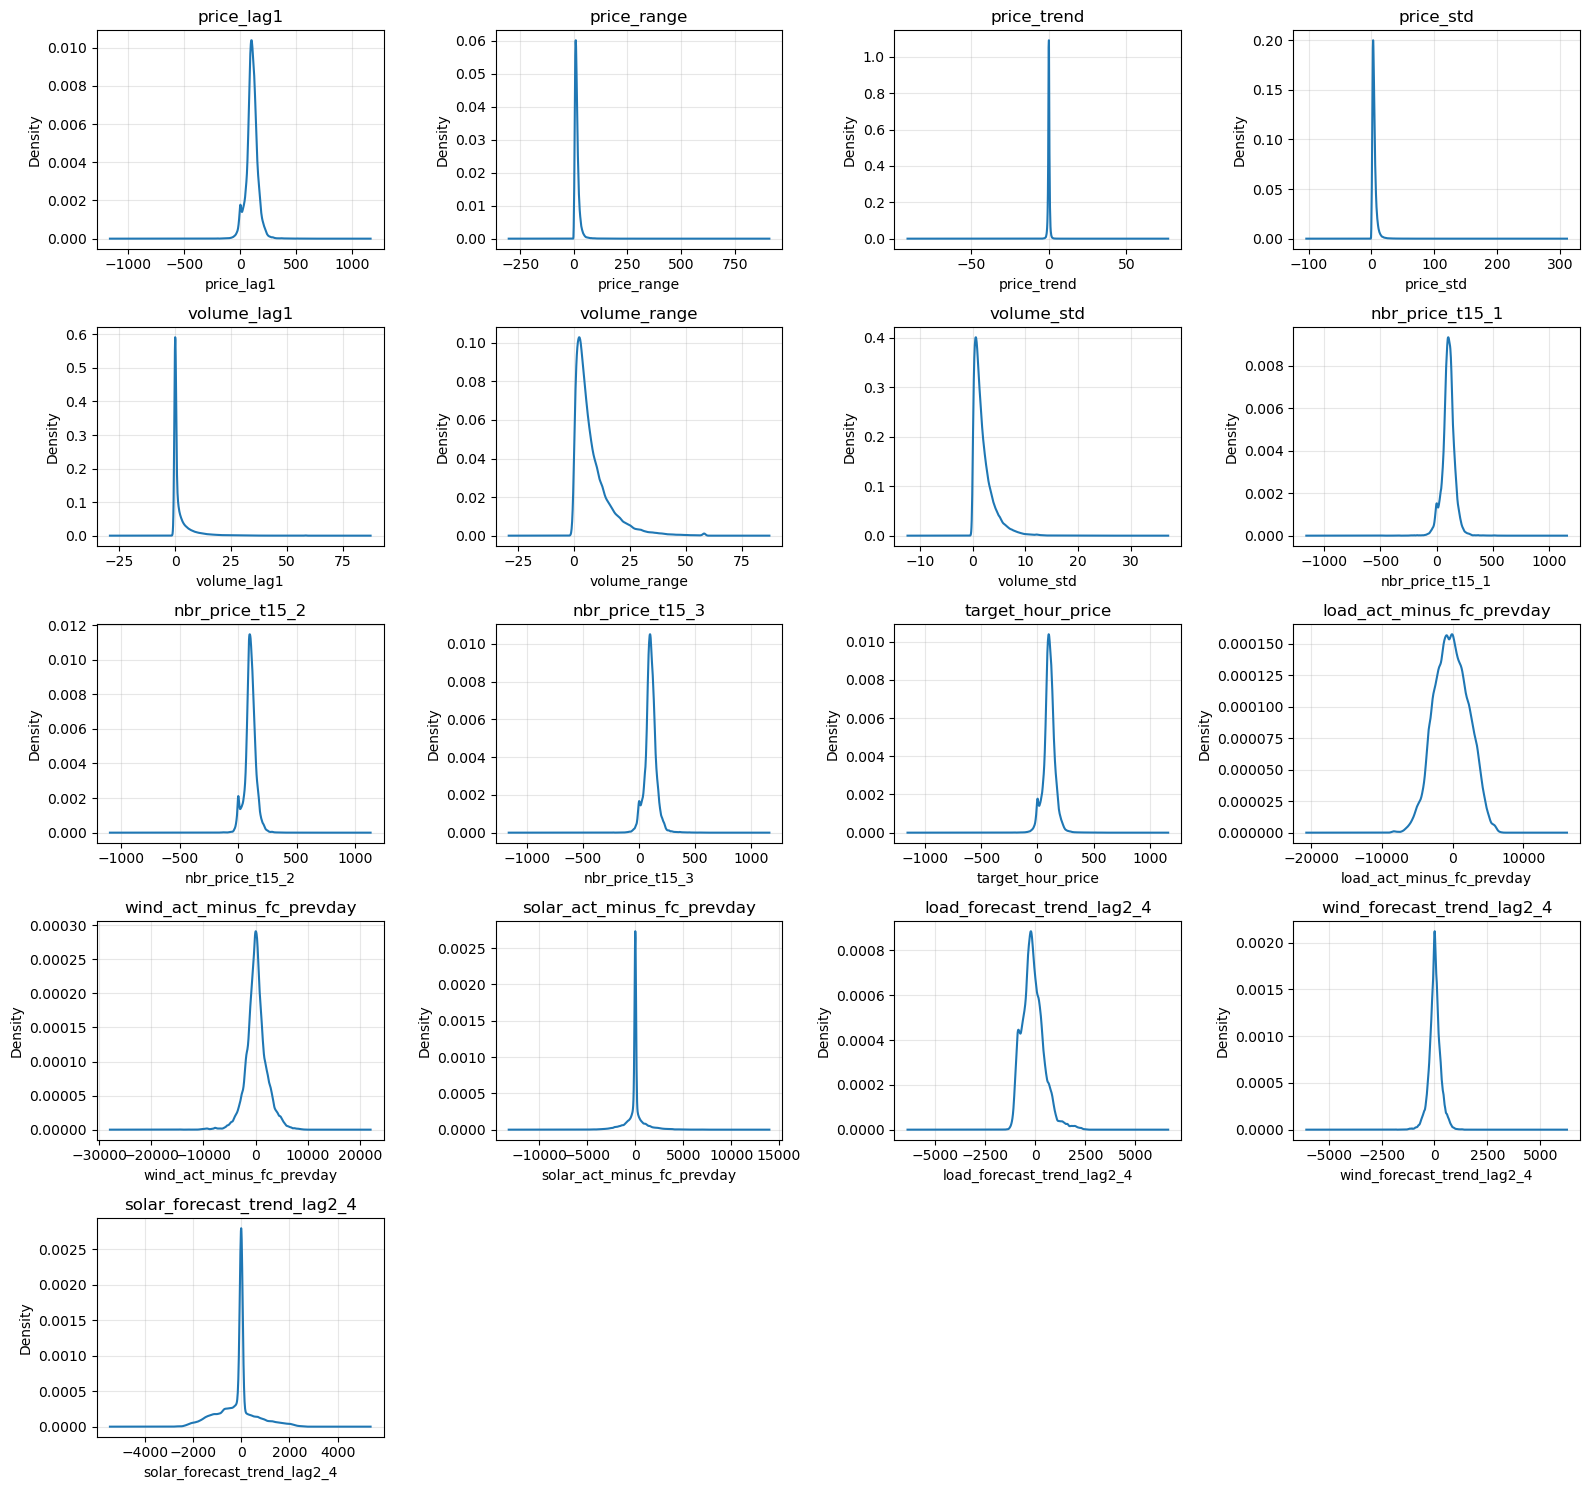

In [26]:
print(f"before scaling: ")
import math
cols = ['price_lag1','price_range','price_trend', 'price_std', 'volume_lag1', 'volume_range','volume_std', 'nbr_price_t15_1',
        'nbr_price_t15_2', 'nbr_price_t15_3','target_hour_price', 'load_act_minus_fc_prevday', 'wind_act_minus_fc_prevday', 'solar_act_minus_fc_prevday' ,
        'load_forecast_trend_lag2_4', 'wind_forecast_trend_lag2_4', 'solar_forecast_trend_lag2_4']
plot_kde_subplots(df_train_wide, cols=cols, cols_per_row=4)


# Model Training

## Lasso and ElasticNet

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer

# ====================================================
# X scaler
# ====================================================

class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mad_cols=(), sparse_cols=(), robust_cols=(), passthrough_cols=()):
        self.mad_cols = list(mad_cols)
        self.sparse_cols = list(sparse_cols)
        self.robust_cols = list(robust_cols)
        self.passthrough_cols = list(passthrough_cols)

        # fitted stats
        self.mad_median_ = None
        self.mad_scale_ = None
        self.sparse_median_ = None
        self.sparse_scale_ = None
        self.robust_median_ = None
        self.robust_scale_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        X = X.copy()
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        # ---- MAD cols ----
        if self.mad_cols:
            A = X[self.mad_cols].to_numpy(dtype=float)
            med = np.nanmedian(A, axis=0)
            mad_raw = np.nanmedian(np.abs(A - med), axis=0)
            c75 = 0.67448975
            scale = mad_raw / c75
            scale = np.where((~np.isfinite(scale)) | (scale == 0), 1.0, scale)
            self.mad_median_ = med
            self.mad_scale_ = scale

        # ---- Sparse cols ----
        if self.sparse_cols:
            A = X[self.sparse_cols].to_numpy(dtype=float)
            A[A == 0] = np.nan  # ignore zeros
            med = np.nanmedian(A, axis=0)
            mad_raw = np.nanmedian(np.abs(A - med), axis=0)
            c75 = 0.67448975
            scale = mad_raw / c75
            scale = np.where((~np.isfinite(scale)) | (scale == 0), 1.0, scale)
            self.sparse_median_ = med
            self.sparse_scale_ = scale

        # ---- Robust cols (Median + MAD, no arcsinh) ----
        if self.robust_cols:
            R = X[self.robust_cols].to_numpy(dtype=float)
            med_r = np.nanmedian(R, axis=0)
            mad_raw = np.nanmedian(np.abs(R - med_r), axis=0)
            c75 = 0.67448975
            scale = mad_raw / c75
            scale = np.where((~np.isfinite(scale)) | (scale == 0), 1.0, scale)
            self.robust_median_ = med_r
            self.robust_scale_ = scale

        return self

    def transform(self, X):
        X = X.copy()

        # ---- MAD cols ----
        if self.mad_cols:
            A = X[self.mad_cols].to_numpy(dtype=float)
            Z = (A - self.mad_median_) / self.mad_scale_
            X[self.mad_cols] = np.arcsinh(Z)

        # ---- Sparse cols ----
        if self.sparse_cols:
            A = X[self.sparse_cols].to_numpy(dtype=float)
            for i, col in enumerate(self.sparse_cols):
                # indicator
                X[f"has_{col}"] = (A[:, i] != 0).astype(int)
                # transform only nonzeros
                nonzero_mask = A[:, i] != 0
                Z = (A[:, i] - self.sparse_median_[i]) / self.sparse_scale_[i]
                Z = np.arcsinh(Z)
                Z[~nonzero_mask] = 0  # keep zeros
                X[col] = Z

        # ---- Robust cols ----
        if self.robust_cols:
            R = X[self.robust_cols].to_numpy(dtype=float)
            Zr = (R - self.robust_median_) / self.robust_scale_
            X[self.robust_cols] = Zr

        return X

    def get_feature_names_out(self, input_features=None):
        extra = [f"has_{c}" for c in self.sparse_cols]
        return np.concatenate([self.feature_names_in_, extra])


# ====================================================
# y scaler
# ====================================================
class TargetMedianMadArcsinh75:
    def __init__(self, eps=1e-12):
        self.eps = eps
        self.c75 = 0.67448975

    def fit(self, Y):
        Y = np.asarray(Y, dtype=float)
        if Y.ndim == 1: Y = Y[:, None]
        self.median_ = np.nanmedian(Y, axis=0)
        mad_raw = np.nanmedian(np.abs(Y - self.median_), axis=0)
        mad_adj = mad_raw / self.c75
        mad_adj[mad_adj < self.eps] = 1.0
        self.mad_ = mad_adj
        return self

    def transform(self, Y):
        Y = np.asarray(Y, dtype=float)
        if Y.ndim == 1: Y = Y[:, None]
        Z = (Y - self.median_) / self.mad_
        return np.arcsinh(Z)

    def inverse_transform(self, Z):
        Z = np.asarray(Z, dtype=float)
        if Z.ndim == 1: Z = Z[:, None]
        X = np.sinh(Z)
        return X * self.mad_ + self.median_


# ====================================================
# metrics
# ====================================================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def smape_rowwise(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * (2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def eval_multioutput(y_true_df, y_pred_nd, target_cols):
    out = {}
    y_pred_nd = np.asarray(y_pred_nd, dtype=float)
    if y_pred_nd.ndim == 1:
        y_pred_nd = y_pred_nd[:, None]
    for i, col in enumerate(target_cols):
        yt = y_true_df.iloc[:, i].to_numpy(dtype=float)
        yp = y_pred_nd[:, i]
        out[col] = {'SMAPE': smape(yt, yp), 'MAE': mean_absolute_error(yt, yp)}
    res = pd.DataFrame(out).T
    avg = res.mean(numeric_only=True).to_frame().T
    avg.index = ['AVERAGE']
    return pd.concat([res, avg], axis=0)

# ====================================================
# divide the train and valid dataset using delivery_date, and to avoid overlap and data leakage, 
# the val_set's date is split_date +1
# ====================================================

def train_val_split_by_date(df, date_col='delivery_time', train_ratio=0.8, drop_split_day=True):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    dates = np.sort(df[date_col].dt.normalize().unique())
    split_idx = int(len(dates) * train_ratio)
    if drop_split_day:
        tr_dates, va_dates = dates[:split_idx], dates[split_idx+1:]
    else:
        tr_dates, va_dates = dates[:split_idx], dates[split_idx:]
    return (
        df[df[date_col].dt.normalize().isin(tr_dates)],
        df[df[date_col].dt.normalize().isin(va_dates)]
    )

def get_feature_importance_from_mor(transformed_feature_names, mor, target_cols):
    names = list(transformed_feature_names)
    coefs = []
    for est in mor.estimators_:
        c = getattr(est, "coef_", None)
        if c is None:
            c = np.zeros(len(names))
        coefs.append(np.asarray(c, dtype=float))
    coef_matrix = np.vstack(coefs)  # [n_targets, n_features]
    use_targets = target_cols[:coef_matrix.shape[0]]
    imp = pd.DataFrame(coef_matrix.T, index=names, columns=use_targets)
    imp["mean_abs_importance"] = imp.abs().mean(axis=1)
    return imp.sort_values("mean_abs_importance", ascending=False)
# ====================================================
# main train function
# ====================================================

def train_val_test_lasso_manual_alpha(
    df_trainvalid, df_test, target_cols,
    mad_cols, sparse_cols, robust_cols,
    alphas=None, max_iter=4000, tol=3e-3, selection="random",
    date_col='delivery_time', datetime_cols=('delivery_time','ExecutionTime','timestamp'),
    drop_split_day=True, l1_ratio=None  # for elasticnet
):
    if alphas is None:
        alphas = np.concatenate([np.logspace(-2, 0, 7), np.array([1.5, 2.0, 3.0])])

    train_df, val_df = train_val_split_by_date(df_trainvalid, date_col, 0.8, drop_split_day)

    def drop_dt(df):
        keep = [c for c in df.columns if c not in datetime_cols]
        return df[keep]

    Xtr_raw, ytr = drop_dt(train_df.drop(columns=target_cols)), train_df[target_cols]
    Xva_raw, yva = drop_dt(val_df.drop(columns=target_cols)),   val_df[target_cols]
    Xte_raw, yte = drop_dt(df_test.drop(columns=target_cols)),  df_test[target_cols]

    # --- X scaler
    pre = CustomScaler(mad_cols=mad_cols, sparse_cols=sparse_cols, robust_cols=robust_cols)
    pre.fit(Xtr_raw)
    Xtr = pre.transform(Xtr_raw)
    Xva = pre.transform(Xva_raw)

    # --- y scaler
    y_scaler = TargetMedianMadArcsinh75().fit(ytr.values)
    ytr_t = y_scaler.transform(ytr.values)


    best_alpha, best_score, best_est = None, np.inf, None
    for a in np.sort(np.asarray(alphas))[::-1]:
        base = ElasticNet(alpha=a, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
        est = MultiOutputRegressor(base, n_jobs=-1)
        est.fit(Xtr, ytr_t)
        yva_pred = y_scaler.inverse_transform(est.predict(Xva))
        score = smape(yva.values, yva_pred)
        if score < best_score:
            best_alpha, best_score, best_est = a, score, est

    # --- train+val
    tv_df = pd.concat([train_df, val_df], axis=0)
    X_tv, y_tv = drop_dt(tv_df.drop(columns=target_cols)), tv_df[target_cols]
    pre_final = CustomScaler(mad_cols=mad_cols, sparse_cols=sparse_cols, robust_cols=robust_cols)
    pre_final.fit(X_tv)
    Xtvt = pre_final.transform(X_tv)

    y_scaler_final = TargetMedianMadArcsinh75().fit(y_tv.values)
    ytv_t = y_scaler_final.transform(y_tv.values)

    final_model = MultiOutputRegressor(
            # can change to Lasso
            ElasticNet(alpha=best_alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, selection=selection),
            n_jobs=-1
    )
    final_model.fit(Xtvt, ytv_t)

    Xte = pre_final.transform(Xte_raw)
    y_pred_test = y_scaler_final.inverse_transform(final_model.predict(Xte))
    y_pred_train = y_scaler_final.inverse_transform(final_model.predict(Xtvt))
    y_pred_val   = y_scaler.inverse_transform(best_est.predict(Xva))

    # --- metrics
    train_results = eval_multioutput(y_tv, y_pred_train, target_cols)
    val_results   = eval_multioutput(yva, y_pred_val, target_cols)
    test_results  = eval_multioutput(yte, y_pred_test, target_cols)

    # --- feature importance
    tf_names = Xtvt.columns if hasattr(Xtvt, "columns") else [f"f{i}" for i in range(Xtvt.shape[1])]
    fi_df = get_feature_importance_from_mor(tf_names, final_model, target_cols)

    # --- row-wise test 
    smape_elem = smape_rowwise(yte.values, y_pred_test)
    smape_per_row = smape_elem.mean(axis=1)
    rowwise_test = df_test.copy().reset_index(drop=True)  # 保留所有列
    for i, col in enumerate(target_cols):
        rowwise_test[f"pred_{col}"] = y_pred_test[:, i]
    rowwise_test["SMAPE_row"] = smape_per_row

    class FittedPipeline:
        def __init__(self, pre, est, y_scaler, datetime_cols):
            self.pre = pre; self.est = est; self.y_scaler = y_scaler
            self.datetime_cols = datetime_cols
        def _drop_dt(self, df):
            keep = [c for c in df.columns if c not in self.datetime_cols]
            return df[keep]
        def predict(self, X_df):
            X_t = self.pre.transform(self._drop_dt(X_df.copy()))
            y_t = self.est.predict(X_t)
            return self.y_scaler.inverse_transform(y_t)

    return {
        'best_alpha': best_alpha,
        'train_results': train_results,
        'val_results': val_results,
        'test_results': test_results,
        'feature_importance': fi_df,
        'rowwise_test': rowwise_test,
        'model': FittedPipeline(pre_final, final_model, y_scaler_final, datetime_cols),
    }


In [ ]:
# prepare for the scaler

target_cols = ['target_hour_price','target_hour_+1h','target_hour_+2h','target_hour_+3h']

mad_cols=['price_lag1','price_range','price_trend', 'price_std', 'nbr_price_t15_1',
    'nbr_price_t15_2', 'nbr_price_t15_3', 'day_ahead_price']

sparse_cols = [
    "imported","exported","volume_lag1","volume_range","volume_std",
    "load_act_minus_fc_prevday","wind_act_minus_fc_prevday",
    "solar_act_minus_fc_prevday",
    "load_forecast_trend_lag2_4","wind_forecast_trend_lag2_4",
    "solar_forecast_trend_lag2_4"
]
robust_cols =['temperature_rounded']

passthrough_cols=['ExecutionTime','ID','delvery_time','day_of_year_sin', 'day_of_year_cos', 'delivery_hour',
    'delivery_hour_sin', 'delivery_hour_cos', 'delivery_weekday_sin',
    'delivery_weekday_cos', 'delivery_month_sin', 'delivery_month_cos']

In [ ]:
df_train_2023 = pd.read_parquet('lightgbm_trainset.parquet')
df_test_wide = pd.read_parquet('lighgbm_testset.parquet')

In [12]:
df_train_2023 = df_train_2023.dropna()
df_test_wide = df_test_wide.dropna()

In [ ]:
results_lasso = train_val_test_lasso_manual_alpha(
    df_trainvalid=df_train_2023,
    df_test=df_test_wide,
    target_cols=target_cols,
    mad_cols=mad_cols,
    sparse_cols=sparse_cols,
    robust_cols=robust_cols,
    alphas= np.logspace(-2, -1, 5),  
    max_iter=3000,
    tol=1e-3,
    selection="random"
)

In [42]:
results_lasso['best_alpha']

np.float64(0.01)

In [ ]:
results_lasso['rowwise_test'].to_parquet('lasso_rowwise_smape.parquet',index=False)
results_lasso['feature_importance'].to_csv('lasso_feature_importance.csv', index=False)

In [37]:
results_lasso['train_results']

SMAPE       MAE
target_hour_price   6.046350  2.771403
target_hour_+1h     9.646327  5.125726
target_hour_+2h    12.302079  6.954794
target_hour_+3h    14.640229  8.594553
AVERAGE            10.658746  5.861619

In [39]:
results_lasso['val_results']

SMAPE       MAE
target_hour_price   5.750212  2.350432
target_hour_+1h     9.075055  4.284159
target_hour_+2h    11.747364  5.839215
target_hour_+3h    14.059852  7.237880
AVERAGE            10.158121  4.927922

In [38]:
results_lasso['test_results']

SMAPE       MAE
target_hour_price   8.768991  2.964058
target_hour_+1h    13.321998  5.309503
target_hour_+2h    16.833334  7.281097
target_hour_+3h    19.932048  9.153039
AVERAGE            14.714093  6.176924

In [ ]:
# Since Lasso has a strong regularization,
# we use Elastic Net with a 0.3 l1 ratio to better check the feature importance
results_en = train_val_test_lasso_manual_alpha(
    df_trainvalid=df_train_2023,
    df_test=df_test_wide,
    target_cols=target_cols,
    mad_cols=mad_cols,
    sparse_cols=sparse_cols,
    robust_cols=robust_cols,
    alphas= [0.005, 0.01, 0.02, 0.03],  
    max_iter=3000,
    tol=1e-3,
    selection="random",
    l1_ratio=0.3 # have tried 0.4,0.5, 0.3 is the best
)

In [41]:
results_en['best_alpha']

np.float64(0.005)

In [40]:
results_en['feature_importance'].to_csv('EN_feature_importance.csv',index=False)
results_en['rowwise_test'].to_parquet('EN_rowwise_smape.parquet',index=False)

In [43]:
results_en['train_results']

SMAPE       MAE
target_hour_price   5.272251  2.489276
target_hour_+1h     9.234837  4.958345
target_hour_+2h    11.968025  6.798599
target_hour_+3h    14.359568  8.440657
AVERAGE            10.208670  5.671719

In [44]:
results_en['val_results']

SMAPE       MAE
target_hour_price   4.864623  1.994777
target_hour_+1h     8.500506  4.004403
target_hour_+2h    11.351453  5.593140
target_hour_+3h    13.737651  7.007286
AVERAGE             9.613558  4.649902

In [45]:
results_en['test_results']

SMAPE       MAE
target_hour_price   6.728402  2.323578
target_hour_+1h    11.759032  4.736009
target_hour_+2h    15.458380  6.720228
target_hour_+3h    18.718568  8.618509
AVERAGE            13.166095  5.599581

## LightGBM

In [50]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# ===== metrics =====
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def smape_rowwise(y_true, y_pred):
    return 100 * (2 * np.abs(y_pred - y_true) /
                  (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def eval_multioutput(y_true_df, y_pred_nd, target_cols):
    out = {}
    y_pred_nd = np.asarray(y_pred_nd, dtype=float)
    if y_pred_nd.ndim == 1:
        y_pred_nd = y_pred_nd[:, None]
    for i, col in enumerate(target_cols):
        yt = y_true_df.iloc[:, i].to_numpy(dtype=float)
        yp = y_pred_nd[:, i]
        out[col] = {'SMAPE': smape(yt, yp),
                    'MAE': mean_absolute_error(yt, yp)}
    res = pd.DataFrame(out).T
    avg = res.mean(numeric_only=True).to_frame().T
    avg.index = ['AVERAGE']
    return pd.concat([res, avg], axis=0)

# ===== LightGBM + TimeSeriesSplit =====
def train_lightgbm_timesplit(
    df_trainvalid, df_test, target_cols,
    date_col="delivery_time", cv_splits=4,
    param_grid=None, random_state=42
):
    # --- 清洗 ---
    df_trainvalid = df_trainvalid.dropna(subset=target_cols).fillna(0).copy()
    df_test       = df_test.dropna(subset=target_cols).fillna(0).copy()

    # --- 时间排序 ---
    for d in (df_trainvalid, df_test):
        d[date_col] = pd.to_datetime(d[date_col])
    df_trainvalid = df_trainvalid.sort_values(date_col)
    df_test       = df_test.sort_values(date_col)

    # --- 特征列 ---
    feat_cols = [c for c in df_trainvalid.columns
                 if c not in set(target_cols) | {'delivery_time','ExecutionTime','timestamp'}]
    X_tv, y_tv = df_trainvalid[feat_cols], df_trainvalid[target_cols]
    X_te, y_te = df_test[feat_cols],  df_test[target_cols]

    # --- 基础模型 ---
    base = LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    est = MultiOutputRegressor(base, n_jobs=-1)

    # --- 参数空间 ---
    if param_grid is None:
        param_grid = {
            "estimator__n_estimators": [300, 500],
            "estimator__num_leaves": [31, 63],
            "estimator__max_depth": [-1, 5],
        }

    # --- scorer (负smape, 越大越好) ---
    scorer = make_scorer(smape, greater_is_better=False)

    # --- TimeSeries CV ---
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    gs = GridSearchCV(
        estimator=est,
        param_grid=param_grid,
        scoring=scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tv, y_tv)

    best_model = gs.best_estimator_
    best_params = gs.best_params_

    # --- 从cv_results里取最佳index ---
    best_idx = gs.best_index_

    # --- CV详细结果: 每个target的SMAPE和MAE ---
    cv_fold_metrics = []
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_idx, val_idx in tscv.split(X_tv):
        Xtr, Xva = X_tv.iloc[train_idx], X_tv.iloc[val_idx]
        ytr, yva = y_tv.iloc[train_idx], y_tv.iloc[val_idx]
        fold_model = clone(best_model)   # 避免覆盖原模型
        fold_model.fit(Xtr, ytr)
        yva_pred = fold_model.predict(Xva)
        metrics_df = eval_multioutput(yva, yva_pred, target_cols)
        cv_fold_metrics.append(metrics_df)

    # --- 平均化（取每个指标的均值） ---
    cv_results_df = pd.concat(cv_fold_metrics).groupby(level=0).mean()

    # --- 预测 ---
    y_pred_train = best_model.predict(X_tv)
    y_pred_test  = best_model.predict(X_te)

    # --- metrics ---
    train_results = eval_multioutput(y_tv, y_pred_train, target_cols)
    test_results  = eval_multioutput(y_te, y_pred_test, target_cols)

    # --- feature importance (avg over targets) ---
    fi_list = []
    for est in best_model.estimators_:
        fi_list.append(est.feature_importances_)
    fi_mean = np.mean(fi_list, axis=0)
    fi_df = pd.DataFrame({
        "feature": feat_cols,
        "importance": fi_mean
    }).sort_values("importance", ascending=False)

    # --- row-wise test ---
    smape_elem = smape_rowwise(y_te.values, y_pred_test)
    smape_per_row = smape_elem.mean(axis=1)
    mae_per_row = np.mean(np.abs(y_pred_test - y_te.values), axis=1)

    rowwise_test = df_test.copy().reset_index(drop=True)
    for i, col in enumerate(target_cols):
        rowwise_test[f"pred_{col}"] = y_pred_test[:, i]
    rowwise_test["SMAPE_row"] = smape_per_row
    rowwise_test["MAE_row"] = mae_per_row

    return {
        "best_params": best_params,
         "cv_results": cv_results_df, 
        "train_results": train_results,
        "test_results": test_results,
        "feature_importance": fi_df,
        "rowwise_test": rowwise_test,
        "model": best_model,
        "feature_cols": feat_cols
    }


In [51]:
target_cols = ['target_hour_price','target_hour_+1h', 'target_hour_+2h','target_hour_+3h']
result_lgm = train_lightgbm_timesplit(
    df_train_2023, df_test_wide, target_cols,
    date_col="delivery_time", cv_splits=4,
    param_grid=None, random_state=42
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6448
[LightGBM] [Info] Number of data points in the train set: 77853, number of used features: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6448
[LightGBM] [Info] Number of data points in the train set: 77853, number of used features: 36
[LightGBM] [Info] Start training from score 131.910368
[LightGBM] [Info] Start training from score 131.747648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6448
[LightGBM] [Info] Number of data points in the train set: 77853, number of used features: 36
[LightGBM] [Info] Start

In [54]:
result_lgm['best_params']

{'estimator__max_depth': -1,
 'estimator__n_estimators': 300,
 'estimator__num_leaves': 31}

In [55]:
result_lgm['cv_results']

SMAPE       MAE
AVERAGE            12.534081  6.594990
target_hour_+1h    11.369437  5.788877
target_hour_+2h    14.459445  7.673830
target_hour_+3h    17.059031  9.513109
target_hour_price   7.248411  3.404144

In [56]:
result_lgm['train_results']

SMAPE       MAE
target_hour_price   5.115649  2.502866
target_hour_+1h     8.885701  4.777462
target_hour_+2h    11.290883  6.392449
target_hour_+3h    13.276336  7.736338
AVERAGE             9.642142  5.352279

In [57]:
result_lgm['test_results']

SMAPE       MAE
target_hour_price   7.090634  2.762378
target_hour_+1h    11.935969  5.068464
target_hour_+2h    15.237158  6.935323
target_hour_+3h    18.159221  8.682787
AVERAGE            13.105745  5.862238

In [59]:
result_lgm['feature_importance'].to_csv('lgm_feature_importance.csv',index=False)
result_lgm['feature_importance']

feature  importance
0                    price_lag1     1533.00
9               nbr_price_t15_2      634.25
11              day_ahead_price      600.50
35             time_to_expiry_h      572.25
12          temperature_rounded      348.75
27              day_of_year_cos      345.25
18                wind_forecast      315.50
26              day_of_year_sin      312.00
17                load_forecast      288.75
21    wind_act_minus_fc_prevday      283.50
24   wind_forecast_trend_lag2_4      275.50
8               nbr_price_t15_1      269.00
19               solar_forecast      259.75
20    load_act_minus_fc_prevday      246.75
10              nbr_price_t15_3      245.25
2                   price_range      236.50
4                   price_trend      225.50
25  solar_forecast_trend_lag2_4      209.50
23   load_forecast_trend_lag2_4      190.75
22   solar_act_minus_fc_prevday      188.75
5                  volume_trend      173.25
1                   volume_lag1      156.75
7                    volume_std      153.25
3                  volume_range      140.50
13                     imported      139.50
6                     price_std      135.75
32         delivery_weekday_cos       97.00
14                     exported       79.00
31         delivery_weekday_sin       71.50
28                delivery_hour       52.25
15             imported_is_zero       49.00
33           delivery_month_sin       47.00
34           delivery_month_cos       37.25
16             exported_is_zero       33.75
29            delivery_hour_sin       27.25
30            delivery_hour_cos       26.00

In [61]:
result_lgm['rowwise_test'].to_parquet('lgm_rowwise_smape.parquet',index=False)
result_lgm['rowwise_test']

delivery_time       ExecutionTime  price_lag1  volume_lag1  \
0      2024-01-07 05:15:00 2024-01-07 02:00:00       81.72        4.575   
1      2024-01-07 05:30:00 2024-01-07 02:00:00       81.45        2.325   
2      2024-01-07 05:45:00 2024-01-07 02:00:00       82.60        2.325   
3      2024-01-07 06:00:00 2024-01-07 02:00:00       77.80        5.025   
4      2024-01-07 06:15:00 2024-01-07 03:00:00       78.71        0.400   
...                    ...                 ...         ...          ...   
243775 2024-08-20 23:45:00 2024-08-20 17:00:00       75.01        6.650   
243776 2024-08-20 23:45:00 2024-08-20 18:00:00       75.34        1.025   
243777 2024-08-20 23:45:00 2024-08-20 19:00:00       89.06       13.600   
243778 2024-08-20 23:45:00 2024-08-20 08:00:00       80.60        0.025   
243779 2024-08-20 23:45:00 2024-08-20 03:00:00       76.36        0.000   

        price_range  volume_range  price_trend  volume_trend  price_std  \
0              7.41         8.050     0.100377      0.236104   1.977760   
1              8.41         7.825     0.164260      0.232143   1.812386   
2              8.27         6.150     0.414039      0.169675   2.857036   
3              8.32        21.250     0.157494     -0.035617   2.561321   
4              7.55        10.425     0.232589      0.016823   2.244458   
...             ...           ...          ...           ...        ...   
243775         7.14        13.975    -0.280623      0.072332   2.233350   
243776        10.21        13.975    -0.354980      0.152668   2.851026   
243777        10.21        29.950    -0.180494      0.714081   3.165845   
243778         3.82         4.025     0.066057      0.009486   1.226872   
243779        12.20        12.275    -0.411156     -0.082559   4.104188   

        volume_std  ...  delivery_weekday_cos  delivery_month_sin  \
0         2.494719  ...               0.62349            0.500000   
1         2.064219  ...               0.62349            0.500000   
2         2.095878  ...               0.62349            0.500000   
3         4.907063  ...               0.62349            0.500000   
4         2.423365  ...               0.62349            0.500000   
...            ...  ...                   ...                 ...   
243775    3.018364  ...               0.62349           -0.866025   
243776    3.357179  ...               0.62349           -0.866025   
243777    8.414541  ...               0.62349           -0.866025   
243778    0.923596  ...               0.62349           -0.866025   
243779    2.754612  ...               0.62349           -0.866025   

        delivery_month_cos  time_to_expiry_h  pred_target_hour_price  \
0                 0.866025              3.25               81.650698   
1                 0.866025              3.50               81.174212   
2                 0.866025              3.75               82.589221   
3                 0.866025              4.00               78.052500   
4                 0.866025              3.25               78.988139   
...                    ...               ...                     ...   
243775           -0.500000              6.75               75.872344   
243776           -0.500000              5.75               76.295955   
243777           -0.500000              4.75               89.156603   
243778           -0.500000             15.75               81.239673   
243779           -0.500000             20.75               77.278298   

        pred_target_hour_+1h  pred_target_hour_+2h pred_target_hour_+3h  \
0                  80.755509             76.956316            76.616282   
1                  80.481942             77.429905            76.237427   
2                  81.590715             78.048499            77.008220   
3                  77.112485             75.939043            73.591884   
4                  78.180945             76.419219            75.153830   
...                      ...                   ...                 